# 关联规则挖掘（Association Rules）
关联规则挖掘是数据挖掘中用于发现变量之间有趣关系的重要技术，最经典的案例就是购物篮分析。MLxtend 提供了完整的关联规则挖掘工具。

##  1. 基本概念
- 事务（transaction）：一笔购物记录（items 列表）。
- 项集（itemset）：若干个商品的集合（例如 {面包, 牛奶}）。
- 支持度（support）：support(𝐴) = 𝑃(𝐴) =（#transactions containing 𝐴） / 𝑁
    - “#transactions containing 𝐴” 的直接意思是：包含项集 A 的交易（Transaction）的数量。
    - 支持度(项集) = (包含该项集的事务数量) / (总事务数量)


- 置信度（confidence）：confidence(𝐴⇒𝐵) = 𝑃(𝐵∣𝐴) = support(𝐴∪𝐵) / support(𝐴)

- 提升度（lift）：lift(𝐴⇒𝐵) = confidence(𝐴⇒𝐵) / support(𝐵) = 𝑃(𝐴∪𝐵) / 𝑃(𝐴)𝑃(𝐵)

    -  lift > 1 表示 A 与 B 正相关；≈1 表示独立；<1 表示负相关。

- 杠杆度（leverage）：leverage = 𝑃(𝐴∪𝐵)−𝑃(𝐴)𝑃(𝐵)

- 置信度反因（conviction）：conviction =（1−𝑃(𝐵)） / （1−confidence(𝐴⇒𝐵)）

    - confidence 趋近 1 时 conviction → ∞。



---
## 2.mlxtend 中常用函数（模块）

- `mlxtend.preprocessing.TransactionEncoder` —— 把 list-of-lists 的事务转换成 `one-hot` DataFrame（apriori 要求的格式）

- `mlxtend.frequent_patterns.apriori` —— 挖掘频繁项集（返回 `itemsets` 与 `support`）

- `mlxtend.frequent_patterns.fpgrowth` —— （可选）`FP-Growth` 算法的实现（在大数据上通常比 apriori 快）

- `mlxtend.frequent_patterns.association_rules` —— 从频繁项集生成关联规则（计算 confidence, lift, leverage, conviction 等

---

### 2.1数据处理模块  TransactionEncoder
将交易数据转换为one-hot编码格式

In [ ]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

# 示例交易数据
transactions = [
    ['牛奶', '面包', '尿布'],
    ['可乐', '面包', '尿布', '啤酒'],
    ['牛奶', '尿布', '啤酒', '鸡蛋'],
    ['面包', '牛奶', '尿布', '啤酒'],
    ['面包', '牛奶', '尿布', '可乐']
]

# 使用TransactionEncoder进行转换
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)

# 转换为DataFrame
df = pd.DataFrame(te_array, columns=te.columns_)
print(df)

输出：

   牛奶    面包    尿布    可乐    啤酒    鸡蛋
0  True   True   True  False  False  False
1  False  True   True   True   True  False
2  True  False   True  False   True   True
3  True   True   True  False   True  False
4  True   True   True   True  False  False

### 2.2频繁项集挖掘 ：Apriori算法

In [ ]:
from mlxtend.frequent_patterns import apriori

# 挖掘频繁项集
frequent_itemsets = apriori(df, 
                           min_support=0.4,  # 最小支持度
                           use_colnames=True) # 使用列名而非索引

print("频繁项集:")
print(frequent_itemsets)

常见参数说明（实用）

- apriori(df, min_support=..., use_colnames=True, max_len=None, verbose=0)

    - `min_support` ：频繁项集的最低支持度阈值（必调）。
    
    - `use_colnames` = `True`：返回` item `名称（更可读）。
    
    - `max_len`：限制项集的最大长度（节省时间/内存）。
 
---

### 2.3频繁项集挖掘 ：FP-Growth算法

In [ ]:
from mlxtend.frequent_patterns import fpgrowth

# 使用FP-Growth算法（更适合大数据集）
frequent_itemsets_fp = fpgrowth(df, 
                               min_support=0.4, 
                               use_colnames=True)

常见参数说明（实用）
- association_rules(df, metric='confidence', min_threshold=0.8)

    - `metric` ：用于筛规则的指标（'support' | 'confidence' | 'lift' | 'leverage' | 'conviction' 等）。

    - `min_threshold` ：对应 metric 的最小阈值。

---

### 2.4关联规则生成 ： association_rules 

In [ ]:
from mlxtend.frequent_patterns import association_rules

# 生成关联规则
rules = association_rules(frequent_itemsets, 
                         metric="confidence",  # 评估指标
                         min_threshold=0.7)    # 最小阈值

print("关联规则:")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

## 3.数据准备要点

`mlxtend `要求的输入是` one-hot `编码的` DataFrame`（列为` item`，值为` 0/1 `或` bool`）。

如果你有原始的事务列表（`list of lists`），用` TransactionEncoder `快速转换（上面模板）。

如果你有购物频次（商品可能出现多次），`APRIORI/FP-GROWTH `只看“`是否出现`”，多次出现不会额外计数；若需考虑数量，可先离散化（比如` milk_qty>=2` -> `"milk_2plus"`）。

对于大类目／长尾商品：先剔除低频商品或只保留` top-k `商品，以降低维度。

---

## 4.完整的实际案例
超市购物篮分析

数据概览:
交易数量: 14
商品种类: 28

商品出现频率:
面包      8
牛奶      6
啤酒      4
黄油      4
薯片      3
奶酪      3
鸡蛋      3
火腿      2
尿布      2
可乐      2
坚果      2
冰淇淋     1
水果      1
橄榄      1
果酱      1
果汁      1
巧克力     1
婴儿食品    1
牛肉干     1
湿巾      1
蛋黄酱     1
葡萄酒     1
茶       1
蜂蜜      1
饼干      1
酸奶      1
香蕉      1
麦片      1
dtype: int64

频繁项集 (支持度 ≥ 0.3):
    support  itemsets
1  0.571429      (面包)
0  0.428571      (牛奶)
2  0.357143  (牛奶, 面包)

关联规则 (提升度 > 1.2):
  antecedents consequents   support  confidence      lift
0        (牛奶)        (面包)  0.357143    0.833333  1.458333
1        (面包)        (牛奶)  0.357143    0.625000  1.458333


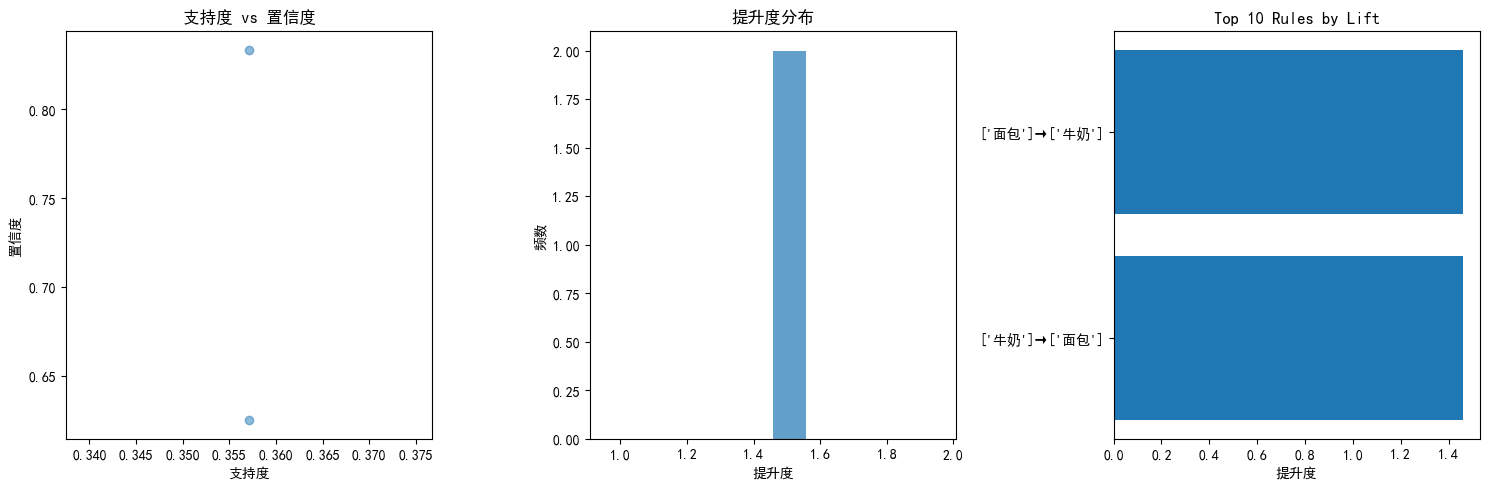

In [8]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
import warnings  # 过滤所有警告 
warnings.filterwarnings('ignore')
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['font.sans-serif'] = ['SimHei']

# 创建更真实的超市交易数据
supermarket_transactions = [
    ['牛奶', '面包', '黄油', '鸡蛋'],
    ['面包', '奶酪', '火腿', '黄油'],
    ['牛奶', '面包', '尿布', '啤酒'],
    ['可乐', '薯片', '啤酒', '坚果'],
    ['牛奶', '鸡蛋', '面包', '水果'],
    ['面包', '黄油', '果酱', '牛奶'],
    ['啤酒', '尿布', '婴儿食品', '湿巾'],
    ['葡萄酒', '奶酪', '饼干', '橄榄'],
    ['牛奶', '麦片', '香蕉', '酸奶'],
    ['面包', '火腿', '奶酪', '蛋黄酱'],
    ['可乐', '冰淇淋', '薯片', '巧克力'],
    ['牛奶', '面包', '鸡蛋', '果汁'],
    ['啤酒', '坚果', '薯片', '牛肉干'],
    ['面包', '黄油', '蜂蜜', '茶']
]

# 数据预处理
te = TransactionEncoder()
te_array = te.fit(supermarket_transactions).transform(supermarket_transactions)
df_supermarket = pd.DataFrame(te_array, columns=te.columns_)

print("数据概览:")
print(f"交易数量: {len(df_supermarket)}")
print(f"商品种类: {len(df_supermarket.columns)}")
print("\n商品出现频率:")
print(df_supermarket.sum().sort_values(ascending=False))

# 挖掘频繁项集
frequent_itemsets = apriori(df_supermarket, 
                           min_support=0.3, 
                           use_colnames=True,
                           max_len=3)  # 最大项集大小

print("\n频繁项集 (支持度 ≥ 0.3):")
print(frequent_itemsets.sort_values('support', ascending=False))

# 生成关联规则
rules = association_rules(frequent_itemsets, 
                         metric="lift", 
                         min_threshold=1.2)

print("\n关联规则 (提升度 > 1.2):")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
      .sort_values('lift', ascending=False))

# 可视化分析
plt.figure(figsize=(15, 5))

# 支持度 vs 置信度散点图
plt.subplot(1, 3, 1)
plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.xlabel('支持度')
plt.ylabel('置信度')
plt.title('支持度 vs 置信度')

# 提升度分布
plt.subplot(1, 3, 2)
plt.hist(rules['lift'], bins=10, alpha=0.7)
plt.xlabel('提升度')
plt.ylabel('频数')
plt.title('提升度分布')

# 前10个规则的提升度
plt.subplot(1, 3, 3)
top_rules = rules.nlargest(10, 'lift')
rules_labels = [f"{list(rule.antecedents)}→{list(rule.consequents)}" 
                for rule in top_rules.itertuples()]
plt.barh(rules_labels, top_rules['lift'])
plt.xlabel('提升度')
plt.title('Top 10 Rules by Lift')
plt.tight_layout()
plt.show()

## 5.高级功能和参数调优
多指标筛选

In [ ]:
# 使用多个指标进行筛选
filtered_rules = association_rules(frequent_itemsets, 
                                  metric="confidence", 
                                  min_threshold=0.6)

# 进一步筛选
final_rules = filtered_rules[
    (filtered_rules['lift'] > 1.2) & 
    (filtered_rules['support'] > 0.2)
]

print("筛选后的规则:")
print(final_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

## 6. 结果解释和业务应用
规则解释示例

In [ ]:
def interpret_rules(rules_df, top_n=5):
    """解释关联规则的业务含义"""
    top_rules = rules_df.nlargest(top_n, 'lift')
    
    for i, rule in top_rules.iterrows():
        antecedents = list(rule['antecedents'])
        consequents = list(rule['consequents'])
        
        print(f"\n规则 {i+1}:")
        print(f"当顾客购买 {antecedents} 时，也会购买 {consequents}")
        print(f"支持度: {rule['support']:.3f} (在所有交易中出现的频率)")
        print(f"置信度: {rule['confidence']:.3f} (规则的可靠性)")
        print(f"提升度: {rule['lift']:.3f} (规则的有效性)")
        
        if rule['lift'] > 1:
            print("✅ 这是一个有效的正相关规则")
        else:
            print("❌ 这个规则可能没有实际意义")

# 解释规则
interpret_rules(rules)

## 7. 实际应用建议
#### 参数选择策略
- min_support：

    - 若是超市零售类（百万笔级），min_support 可以设得较小（0.01 以下）以发现长尾组合；
    
    - 小数据集建议 0.1 ~ 0.3 以减少噪声。

- min_confidence：常用 0.5~0.8。

- lift：用来发现有实际关联（>1.2、>1.5 依据业务严格度）。

- metric选择:

    - 寻找强关联: confidence > 0.7
    
    - 寻找有趣规则: lift > 1.2
    
    - 平衡考虑: 结合support和confidence

结合业务 KPIs：不要只看统计指标，也看规则是否能带来交叉销售提升、促销逻辑或产品组合优化


#### 业务应用场景
- 商品摆放优化: 将关联商品摆放在相近位置

- 促销策略: 对关联商品进行捆绑销售

- 库存管理: 根据关联规则预测商品需求

- 推荐系统: 基于购买历史推荐关联商品

---
## 8.常见陷阱 & 注意事项

- 支持度太低：会产生大量噪声规则；太高又可能漏掉有价值的长尾规则。

- 置信度误导：高置信度不一定意味着强关联（若` consequent `很常见）。这时用` lift `进行补充判定。

- 频繁项集与规则解释：`apriori` 根据存在/不存在工作，不计算商品数量；若你关心“购买 3 瓶牛奶”这种情况，需要先把数量离散化成“milk_>=3”。

- 数据稀疏 / 维度高：先降维（过滤低频商品或只使用` top-K `类目）会明显加速计算且结果更易解释。

- 时间/序列信息：关联规则不保留事务顺序；若需要顺序模式（序列规则），需使用序列模式挖掘算法（不是 apriori/association_rules 的范畴）。